In [19]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import keras.applications.xception as xception

# Function to extract image name without extension
def extract_image_name(filename):
    return os.path.splitext(filename)[0]

def generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, img_size=(299, 299), alpha=0.4, cam_path="save_cam_image.jpg", original_name=None):
    # Load image
    def get_img_array(img_path, size):
        img = load_img(img_path, target_size=size)
        array = img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array

    # Generate Grad-CAM heatmap
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])  #預測結果中的最高機率類別
            class_channel = preds[:, pred_index] 

        grads = tape.gradient(class_channel, last_conv_layer_output) #每個像素在該類別中的重要性
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]

        #生成特徵圖
        cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
        cam = tf.nn.relu(cam)

        heatmap = cam / tf.reduce_max(cam)
        return heatmap.numpy()

    # Save and display Grad-CAM:存取在code所位於的目錄
    def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
        img = load_img(img_path)
        img = img_to_array(img)

        heatmap = np.uint8(255 * heatmap)

        jet = mpl.cm.get_cmap("jet")

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = img_to_array(jet_heatmap)

        Superimposed_img = jet_heatmap * alpha + img
        Superimposed_img = array_to_img(Superimposed_img)

        Superimposed_img.save(cam_path)
        display(IPImage(cam_path))

  
    #各函式依順序執行
    # Preprocess and prepare the image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model with imagenet dataset
    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, cam_path=cam_path, alpha=alpha)


執行大函式中包的三小函式

C:\Users\BOIL\AppData\Local\Temp\ipykernel_22620\4145517893.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap("jet")


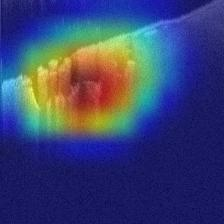

In [5]:
output_png_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\cal\01272_supra3_h_frame665.png'

# Call the function with required parameters
generate_and_display_gradcam(
    img_path=output_png_path,
    model_builder=xception.Xception,
    last_conv_layer_name="block14_sepconv2_act",
    preprocess_input=xception.preprocess_input,
    decode_predictions=xception.decode_predictions,
    img_size=(299, 299),
    alpha=0.4,
    cam_path="save_cam_image.jpg"
)

把整個folder的file都用gradCAM處理過

利用OCT影像中的灰度值变化来检测和区分正常和异常的牙结石 ->

使用Canny进行边缘检测：生成边缘图像。
计算边缘的平滑度：通过计算边缘图像中的梯度变化或连通组件的形状特征来评估平滑度。
设定阈值进行分类：根据平滑度指标将图像分类为牙结石或正常影像。

測試threshold_multiotsu(有進展)

成功圈選出grayscale輪廓

In [3]:
import sys
sys.path.append(r"D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\reqiured_funcs") #存取所需函式的路徑


In [ ]:
from del_files import delete_files_in_directory

output_dir = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\dental_calculus_profile'

# # 刪除檔案
delete_files_in_directory(output_dir)


每張OCT加gradCAM

In [ ]:
import glob

# Process all images in the specified directory
imgs_path = glob.glob(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\cal\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input
decode_predictions = xception.decode_predictions

#建存cam影像目錄
cam_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\cal_CAM'
os.makedirs(cam_path, exist_ok=True)

def extract_image_name(filename):
    return os.path.splitext(filename)[0]

# Loop through all image paths and generate Grad-CAM for each
for img_path in imgs_path:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(cam_path, f'{img_name}_cam.jpg')
    # print(cam_output_path)
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, cam_path=cam_output_path)

In [ ]:
import glob

# Process all images in the specified directory
imgs_path = glob.glob(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\nor\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input
decode_predictions = xception.decode_predictions

#建存cam影像目錄
cam_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\nor_CAM'
os.makedirs(cam_path, exist_ok=True)


# Loop through all image paths and generate Grad-CAM for each
for img_path in imgs_path:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(cam_path, f'{img_name}_cam.jpg')
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, cam_path=cam_output_path)

In [13]:
import glob

# Process all images in the specified directory
imgs_path = glob.glob(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input
decode_predictions = xception.decode_predictions

#建存cam影像目錄
cam_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\CAM_outputs'
os.makedirs(cam_path, exist_ok=True)


# Loop through all image paths and generate Grad-CAM for each
for img_path in imgs_path:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\CAM_outputs', f'{img_name}_cam.jpg')
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, cam_path=cam_output_path)

用6/13supra h新data 加CAM

In [ ]:
import os
import glob

# 定义根目录
root_dir = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png'

# 找到所有以 'cal' 或 'nor' 开头的子目录
sub_dirs = [os.path.join(root_dir, sub_dir) for sub_dir in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, sub_dir)) and (sub_dir.startswith('cal') or sub_dir.startswith('nor'))]

# 找到所有符合条件的PNG文件
png_files = []
for sub_dir in sub_dirs:
    png_files.extend(glob.glob(os.path.join(sub_dir, '*.png')))

# print(png_files)

# Process all images in the specified directory
# imgs_path = glob.glob(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\*.png')
model_builder = xception.Xception  # Replace with your model
last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
preprocess_input = xception.preprocess_input
decode_predictions = xception.decode_predictions

#建存cam影像目錄
cam_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_6_13DC\test_png\CAM_outputs'
os.makedirs(cam_path, exist_ok=True)


# Loop through all image paths and generate Grad-CAM for each
for img_path in png_files:
    img_name = extract_image_name(os.path.basename(img_path))
    cam_output_path = os.path.join(cam_path, f'{img_name}_cam.jpg')
    generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, cam_path=cam_output_path)


大函式解體，分別執行小函式(方便觀察)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image as IPImage, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

output_png_path = r'\\BOIL-NAS\home\Dental OCT\tooth_data_png\201903220033.png'

# 打开 TIFF 文件

#display(IPImage(img_path))  # 秀原圖
display(IPImage(output_png_path))


"""利用load_img載入圖像並用img_to_array轉成array，並擴展維度，跟pretrained好的Xception model互相匹配"""
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    ## We add a dimension to transform our array into a "batch" : because model expect input_shape:(batch_size, height, width, channels)
    array = np.expand_dims(array, axis=0)
    return array

"""從輸入映射到輸出"""
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient : use global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]

    #原本算法
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # GAP
    # heatmap = tf.squeeze(heatmap)

    # ## For visualization purpose
    # heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    #試看看別種計算grad方式，看是否能降噪
    # 计算CAM
    cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    cam = tf.nn.relu(cam)

    # 归一化CAM
    heatmap = cam / tf.reduce_max(cam)

    return heatmap.numpy()

In [ ]:
## Preparing the image
img_array = preprocess_input(get_img_array(output_png_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = load_img(img_path)
    img = img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)
   

    ## Displaying Grad CAM
    display(IPImage(cam_path))


save_and_display_gradcam(output_png_path, heatmap)

for loop處理整個folder的圖片，轉為grad-CAM(之前跑的影像會有失真，尚未解決)

In [ ]:
import os
output_png_path = r'\\BOIL-NAS\homes\311514061\Dental OCT\tooth_data_png'
save_cam_path=r'\\BOIL-NAS\homes\311514061\Dental OCT\tooth_data_cam'
os.makedirs(save_cam_path,exist_ok=True)



# Get a sorted list of filenames
sorted_filenames = sorted([filename for filename in os.listdir(output_png_path) if filename.endswith('.png')])  # 照順序輸出png檔
for filename in sorted_filenames:
    #print(filename)
    img_array = preprocess_input(get_img_array(output_png_path, size=img_size))


    preds = model.predict(img_array)
    
    ## Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(output_png_path, heatmap, cam_path=os.path.join(save_cam_path, filename))